Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TH1F::Add>: Attempt to add histograms with different number of bins - trying to use TH1::Merge
Info in <TCanvas::Print>: png file /Users/chris/Desktop/MC/data/plots/simonebib_withrealib_split_logy.png has been created


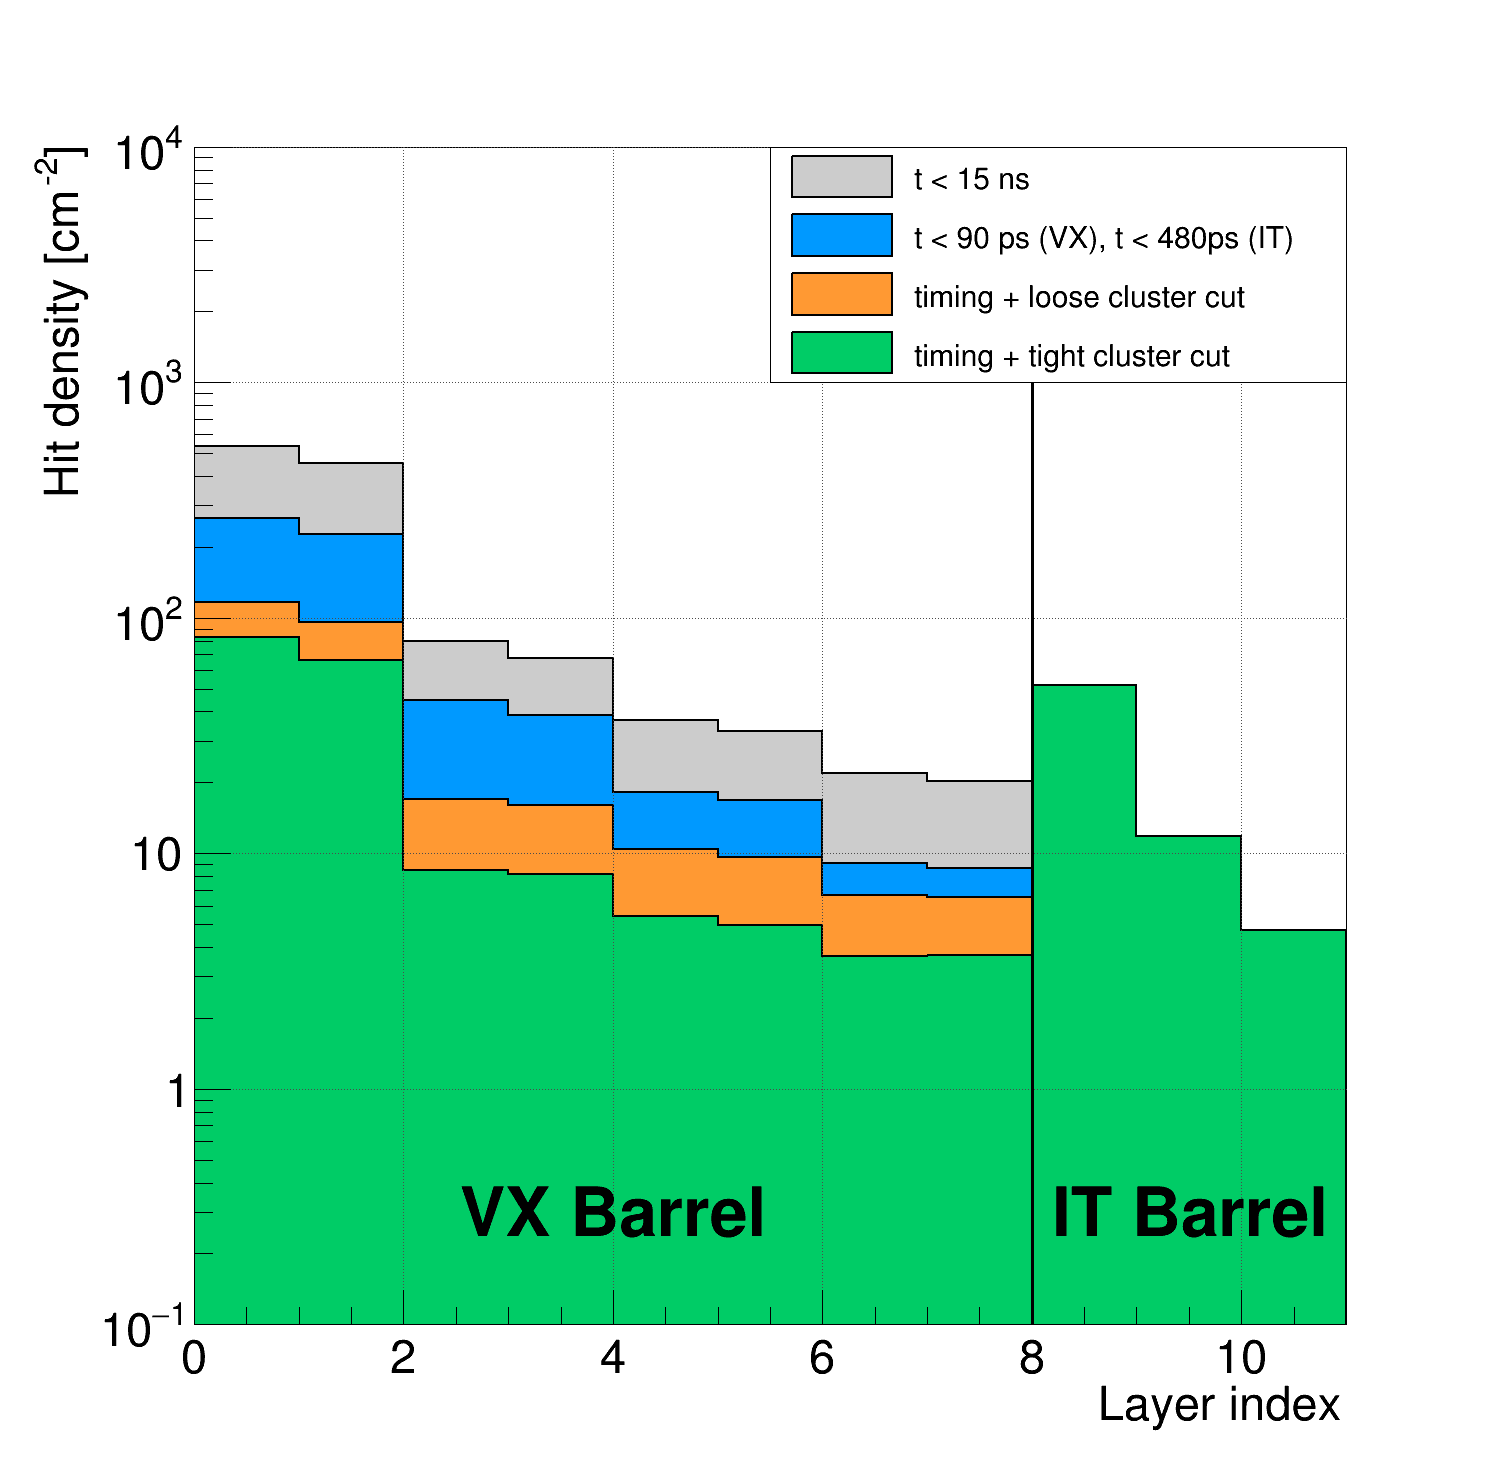

In [16]:
##########################################

# VXDBplots.py
# Imports local data from output root files and extracts contents to create a plot
# June 27, 2023
# Chris Sellgren, UCSB/LBNL/IRIS-HEP

##########################################

import ROOT as R
import math
import os
import numpy as np

R.gStyle.SetOptStat(0)
R.gStyle.SetGridColor(14)
R.gStyle.SetPadRightMargin(0.03)
R.gStyle.SetPadLeftMargin(0.12)

# hard coded values for the sensor layer areas
sens_area = {}
for sub in range(2):
    sens_area.update({('b',l*2+sub): 1e-2*130*a for l, a in enumerate([16*13,15*23,21*24,29*24])})

sens_area_ib = {}
sens_area_ib.update({('b',l): a for l, a in enumerate([8117.85,22034.16,51678.81])})
    
# set canvas
C = R.TCanvas('canvas','',1500,1500)
# R.gStyle.SetPalette(R.kBird)
C.SetLeftMargin(0.13)
C.SetRightMargin(0.1)
C.SetGrid(1,1)

# pull files from local drive
STUDY_NAME = "simonebib_withrealib"
DIR_IN = '/Users/chris/Desktop/MC/data/myruns_vxdbstudy/' + STUDY_NAME
DIR_OUT = '/Users/chris/Desktop/MC/data/plots'
NAMES = ['notimingcut','timingcut', 'loosecluster','tightcluster']
files_in = [R.TFile(os.path.join(DIR_IN,f'histograms_{n}.root')) for n in NAMES]

# extract contents from files
nH = len(NAMES)
histos_vb = [files_in[i].MyTrackPerf.clusters_vb.numhits_by_layer for i in range(nH)]
histos_ib = [files_in[i].MyTrackPerf.clusters_ib.numhits_by_layer for i in range(nH)]


histos = [R.TH1F(f'h{i:d}', ';Layer;Hit density [cm^{-2}]', 16, 0, 16) for i in range(nH)]
for i,h in enumerate(histos_ib):
    # noramlize by sensor area, shift bins by 8.
    for l in range(3):
        histos[i].SetBinContent(l+9, h.GetBinContent(l+1) / sens_area_ib[('b', l)])
        #h.SetBinContent(l+1, 0)
        
for iH, h in enumerate(histos_vb):
    h.Draw()
    
    # noramlize by sensor area
    for l in range(8):
        h.SetBinContent(l+9, 0)
        h.SetBinContent(l+1, h.GetBinContent(l+1) / sens_area[('b', l)])
    
    h.Add(histos[iH])
        
# make plot
names = [
    't < 15 ns',
    't < 90 ps (VX), t < 480ps (IT)',
    'timing + loose cluster cut',
    'timing + tight cluster cut',
]

R.gStyle.SetGridColor(12)
C.Clear()
C.cd()
C.SetGrid(1)

leg = R.TLegend(0.515, 0.74, 0.9, 0.9)
colors = [12, R.kAzure+2, R.kPink+2, R.kAzure+7, R.kTeal+2]
fills = [17,R.kAzure+7, R.kOrange+1, R.kTeal+2]
# colors = [1, 11, 15]
# fills = [0, 12, 16]
yMax = 1e4
h_ax = R.TH1F('h_ax', '"New" BIB;Layer index;Hit density [cm^{-2}]', 11, 0, 11)
#h_ax.GetYaxis().SetMaxDigits(4)
C.SetLogy(True)
h_ax.SetAxisRange(1e-1, 1e4, 'Y')
# Optimising the X axis
a = h_ax.GetXaxis()
#a.SetNdivisions(-208)
# Drawing the axes
h_ax.Draw('AXIS')
h_ax.Draw('AXIG same')
# Drawing
for iT, h in enumerate(histos_vb):
    h.SetLineColor(1)
    h.SetFillColor(fills[iT])
    h.SetLineWidth(2)
    leg_type = 'F'
    leg.AddEntry(h, names[iT], leg_type)
    h.Draw('HIST same')
h_ax.Draw('AXIG same')
leg.Draw()
C.Draw()
C.RedrawAxis()
# Drawing text labels
t1 = R.TText(4, 3e-1, 'VX Barrel')
t2 = R.TText(9.5, 3e-1, 'IT Barrel')

for t in [t1,t2]:
    t.SetTextAlign(22)
    t.SetTextColor(1)
    t.Draw()
    
# Drawing vertical separator
l = R.TLine(8, 0, 8, 1e3)
l.SetLineWidth(3)
l.SetLineColor(1)
l.Draw()
C.SaveAs(os.path.join(DIR_OUT,STUDY_NAME+"_split_logy.png"))